# Использование ежедневных обменных курсов валют для предсказания ВВП и ИПЦ

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from itertools import product
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, mean_absolute_error


from midas.mix import mix_freq, mix_freq2
from midas.adl import estimate, forecast, midas_adl, rmse, estimate2,forecast2, midas_adl2

In [2]:
ex_rates = pd.read_csv('ex_rates.csv', parse_dates=['DATE'], dayfirst=True, index_col='DATE', sep=';')['2016-07-01':'2023-06-30']
ex_rates['usd_byn'] = ex_rates['usd_byn'].str.replace(" ", "").astype(float)
ex_rates['eur_byn'] = ex_rates['eur_byn'].str.replace(" ", "").astype(float)
ex_rates.tail()

,usd_byn,eur_byn,rur_byn
DATE,,,
2023-06-26,2.9890,3.2467,3.5652
2023-06-27,3.0077,3.2773,3.5475
2023-06-28,3.0108,3.2941,3.5444
2023-06-29,3.0149,3.3007,3.5246
2023-06-30,3.0315,3.3098,3.4840


In [3]:
usd = adfuller(ex_rates['usd_byn'])
rur = adfuller(ex_rates['rur_byn'])
eur = adfuller(ex_rates['eur_byn'])

DF_test = pd.DataFrame([[usd[0], eur[0], rur[0]], [usd[1], eur[1], rur[1]]], index=["ADF Statistic", "p-value:"], columns=["usd_byn", "eur_byn", "rur_byn"])
DF_test

,usd_byn,eur_byn,rur_byn
ADF Statistic,-0.846668,-1.273437,-2.277928
p-value:,0.805028,0.641236,0.179185


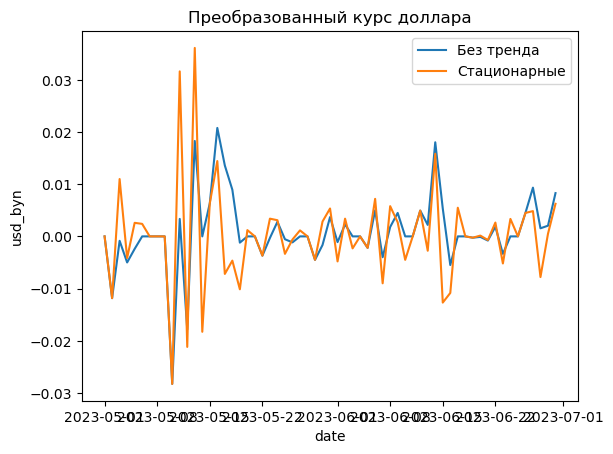

In [4]:
# Преобразование для удаления тренда
ex_rates['usd_byn_no_trend'] = ex_rates['usd_byn'] - ex_rates['usd_byn'].rolling(window=2).mean()

# Преобразование для удаления сезонности (в данном случае просто разница между текущим и предыдущим значением)
ex_rates['usd_byn_stationary'] = ex_rates['usd_byn_no_trend'].diff()

# Удалим первые строки с пропущенными значениями
ex_rates.dropna(inplace=True)

# Построим графики
plt.plot(ex_rates['usd_byn_no_trend']['2023-05-01':], label='Без тренда')
plt.plot(ex_rates['usd_byn_stationary']['2023-05-01':], label='Стационарные')
plt.legend()
plt.title('Преобразованный курс доллара')
plt.xlabel('date')
plt.ylabel('usd_byn')
plt.show()

In [5]:
# Преобразование для удаления тренда
ex_rates['eur_byn_no_trend'] = ex_rates['eur_byn'] - ex_rates['eur_byn'].rolling(window=2).mean()

# Преобразование для удаления сезонности (в данном случае просто разница между текущим и предыдущим значением)
ex_rates['eur_byn_stationary'] = ex_rates['eur_byn_no_trend'].diff()

# Удалим первые строки с пропущенными значениями
ex_rates.dropna(inplace=True)

# Преобразование для удаления тренда
ex_rates['rur_byn_no_trend'] = ex_rates['rur_byn'] - ex_rates['rur_byn'].rolling(window=2).mean()

# Преобразование для удаления сезонности (в данном случае просто разница между текущим и предыдущим значением)
ex_rates['rur_byn_stationary'] = ex_rates['rur_byn_no_trend'].diff()

# Удалим первые строки с пропущенными значениями
ex_rates.dropna(inplace=True)

In [6]:
usd = adfuller(ex_rates['usd_byn_stationary'])
rur = adfuller(ex_rates['eur_byn_stationary'])
eur = adfuller(ex_rates['rur_byn_stationary'])

DF_test = pd.DataFrame([[usd[0], eur[0], rur[0]], [usd[1], eur[1], rur[1]]], index=["ADF Statistic", "p-value:"], columns=["usd_byn", "eur_byn", "rur_byn"])
DF_test

,usd_byn,eur_byn,rur_byn
ADF Statistic,-1.453834e+01,-1.717257e+01,-1.654162e+01
p-value:,5.194732e-27,6.728164e-30,1.981499e-29


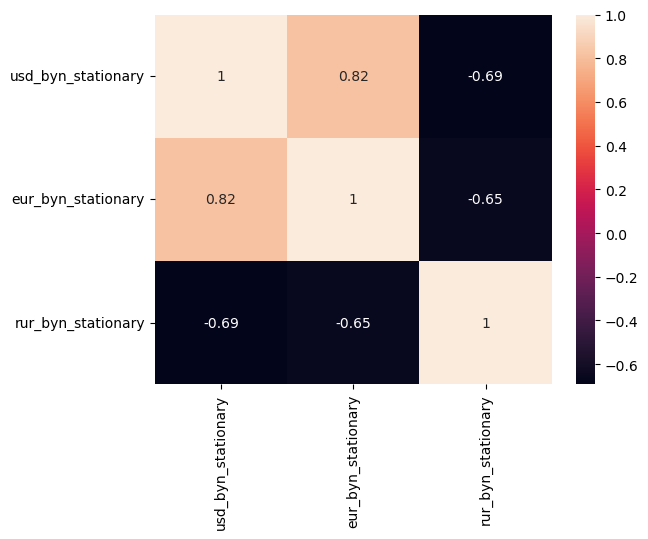

In [7]:
sns.heatmap(ex_rates[['usd_byn_stationary', 'eur_byn_stationary', 'rur_byn_stationary']].corr(), annot = True)
None

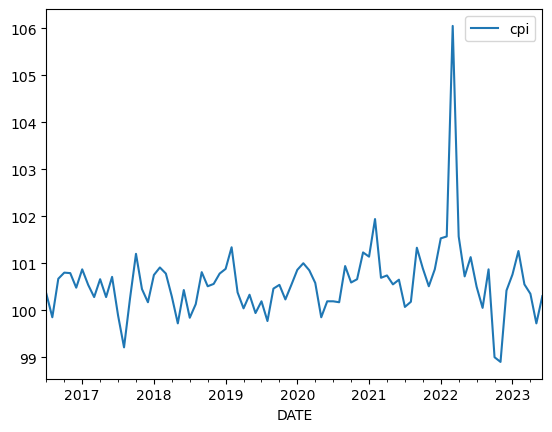

In [8]:
gdp_cpi = pd.read_csv('gdp_cpi_mm.csv', parse_dates=['DATE'], dayfirst=True, index_col='DATE', sep=';')
gdp_cpi = gdp_cpi.rename(columns={'GDP' : 'gdp', 'CPI' : 'cpi'})
cpi = gdp_cpi[['cpi']]
cpi.loc['2016-07-01':].plot()
None

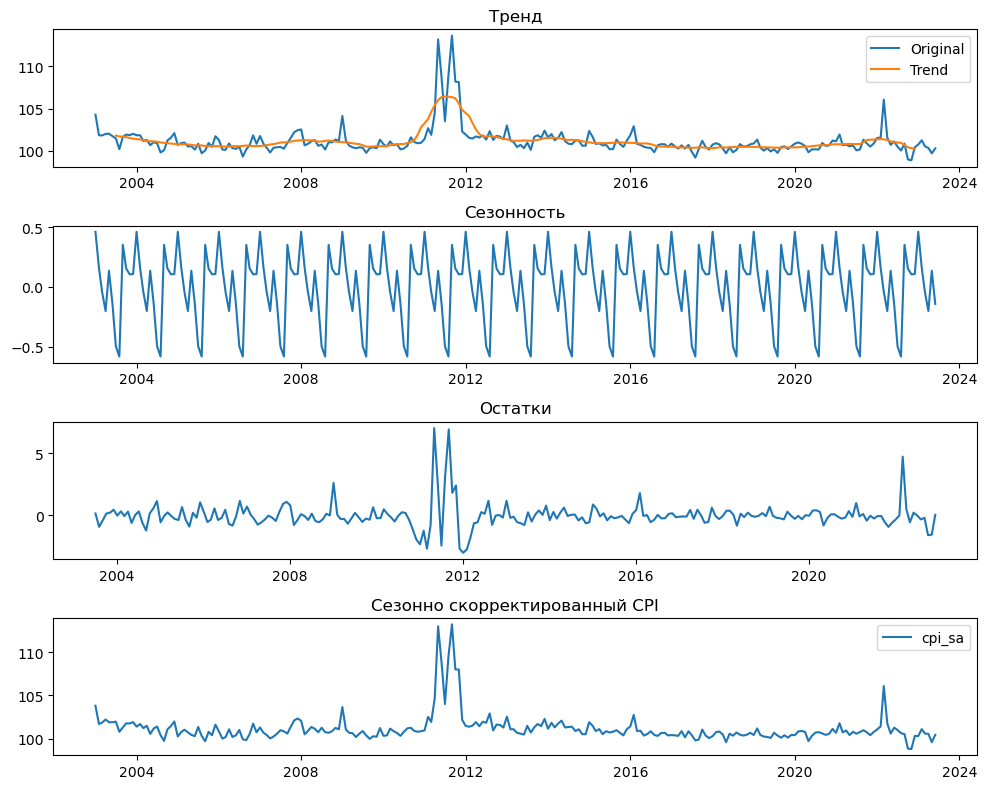

In [9]:
# Выполнение сезонной декомпозиции
decomposition = seasonal_decompose(cpi.cpi, model='additive', period=12)

# Получение тренда, сезонности и остатков
trend = decomposition.trend
seasonal = decomposition.seasonal
residuals = decomposition.resid

# Визуализация результатов
plt.figure(figsize=(10, 8))

# Вывод тренда
plt.subplot(411)
plt.plot(cpi.cpi, label='Original')
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.title('Тренд')

# Вывод сезонности
plt.subplot(412)
plt.plot(seasonal)
plt.title('Сезонность')

# Вывод остатков
plt.subplot(413)
plt.plot(residuals)
plt.title('Остатки')

cpi_sa = pd.DataFrame(cpi.cpi - seasonal, columns=['cpi_sa'])

# Вывод исходных данных без сезонности
plt.subplot(414)
plt.plot(cpi_sa, label='cpi_sa')
plt.legend(loc='best')
plt.title('Сезонно скорректированный CPI')

plt.tight_layout()
plt.show()

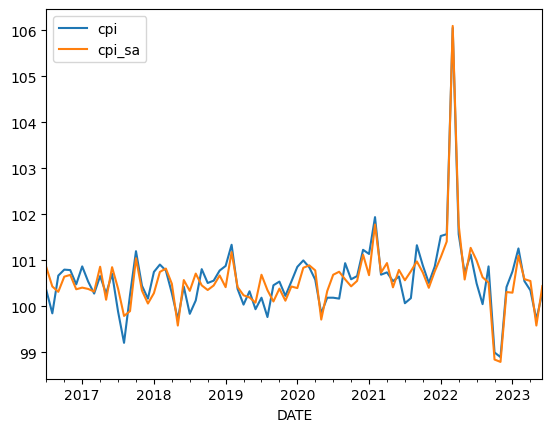

In [10]:
pd.concat([cpi, cpi_sa], axis=1).loc['2016-07-01':].plot()
None

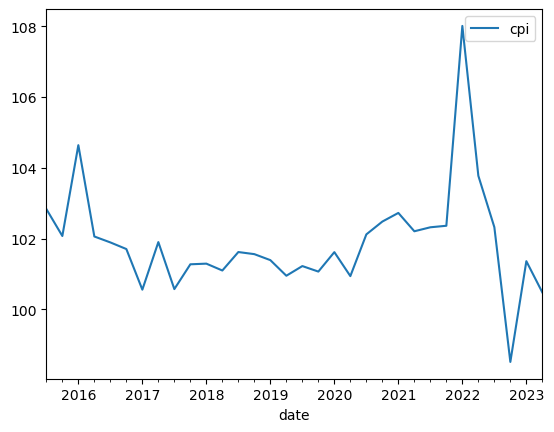

In [11]:
cpi_q = pd.read_csv('CPI_RB.csv', parse_dates=['date'], dayfirst=True, index_col='date', sep=';').loc['2015-07-01':]
cpi_q = cpi_q.rename(columns={'CPI_QQ' : 'cpi'})
cpi_q.dropna(inplace=True)
cpi_q.plot()
None

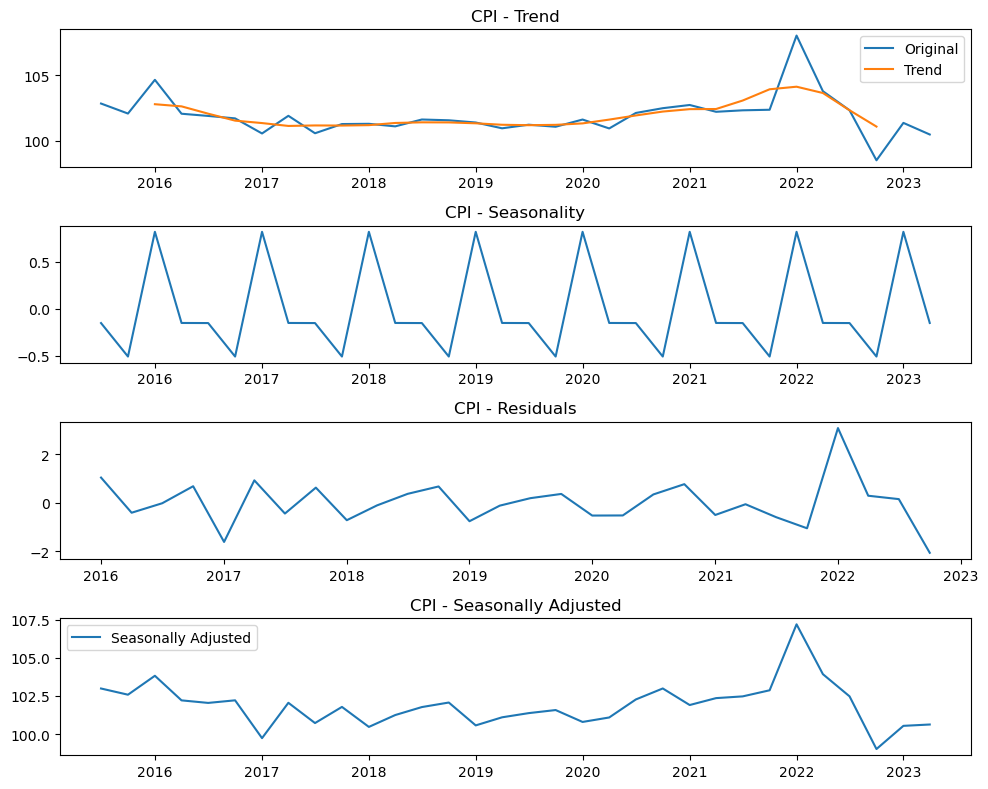

In [12]:
# Выполнение сезонной декомпозиции
decomposition = seasonal_decompose(cpi_q.cpi, model='additive', period=4)

# Получение тренда, сезонности и остатков
trend = decomposition.trend
seasonal = decomposition.seasonal
residuals = decomposition.resid

# Визуализация результатов
plt.figure(figsize=(10, 8))

# Вывод тренда
plt.subplot(411)
plt.plot(cpi_q.cpi, label='Original')
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.title('CPI - Trend')

# Вывод сезонности
plt.subplot(412)
plt.plot(seasonal)
plt.title('CPI - Seasonality')

# Вывод остатков
plt.subplot(413)
plt.plot(residuals)
plt.title('CPI - Residuals')

cpi_q_sa = pd.DataFrame(cpi_q.cpi - seasonal, columns=['cpi_sa'])

# Вывод исходных данных без сезонности
plt.subplot(414)
plt.plot(cpi_q_sa, label='Seasonally Adjusted')
plt.legend(loc='best')
plt.title('CPI - Seasonally Adjusted')

plt.tight_layout()
plt.show()

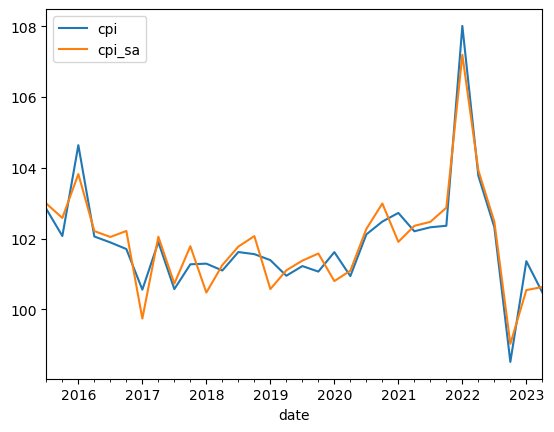

In [13]:
pd.concat([cpi_q, cpi_q_sa], axis=1).loc['2015-01-01':].plot()
None

# Прогнозирование CPI_MM

In [96]:
df = pd.concat([cpi_sa, ex_rates[['usd_byn_stationary']]], axis=1)
DUM2022m03 = pd.DataFrame([0 for _ in range(cpi.shape[0])], columns=['dum'], index=cpi.index)
DUM2022m03.loc['2022-03-01'] = 1
DUM2022m10m11 = pd.DataFrame([0 for _ in range(cpi.shape[0])], columns=['dum'], index=cpi.index)
DUM2022m10m11.loc['2022-10-01'] = 1
DUM2022m10m11.loc['2022-11-01'] = 1
target = pd.concat([cpi_sa.cpi_sa,  DUM2022m03, DUM2022m10m11], axis=1)

# Exp Almon Lags

## Параметры (1, 1)

In [113]:
K_1 = 1
K_2 = 2
y, yl, x, yf, ylf, xf = mix_freq(target, ex_rates.usd_byn_stationary, K_1, K_2, 2,
                                 start_date=datetime.datetime(2016,7,1),
                                 end_date=datetime.datetime(2021,7,1))
model = estimate(y.cpi_sa, yl, x, poly='expalmon')
print(*model.x)
#opt params [beta0, beta1, beta2, theta11, theta12, theta21, theta22, lambda]

91.89182995840254 -28.539830046966323 -1.0 0.0 0.1174218841855037 0.0 0.0 -0.03180321127724639 0.0 0.0


In [114]:
fc = forecast(xf, ylf, model, poly='expalmon')
forecast_df = fc.join(yf)
forecast_df['residual'] = forecast_df.yfh - forecast_df.cpi_sa
print('RMSE =', np.sqrt(mean_squared_error(cpi_sa[['cpi_sa']].loc['2021-08-01':'2023-06-01'], forecast_df.yfh)))
print('MAE =', mean_absolute_error(cpi_sa[['cpi_sa']].loc['2021-08-01':'2023-06-01'], forecast_df.yfh))
forecast_df.head()

RMSE = 1.336312287978921
MAE = 0.7294363632088625


,yfh,cpi_sa,dum,dum,residual
DATE,,,,,
2021-08-01,100.642218,100.764004,0,0,-0.121785
2021-09-01,100.525326,100.978129,0,0,-0.452802
2021-10-01,100.370160,100.737024,0,0,-0.366864
2021-11-01,100.783115,100.405254,0,0,0.377861
2021-12-01,100.477843,100.763420,0,0,-0.285577


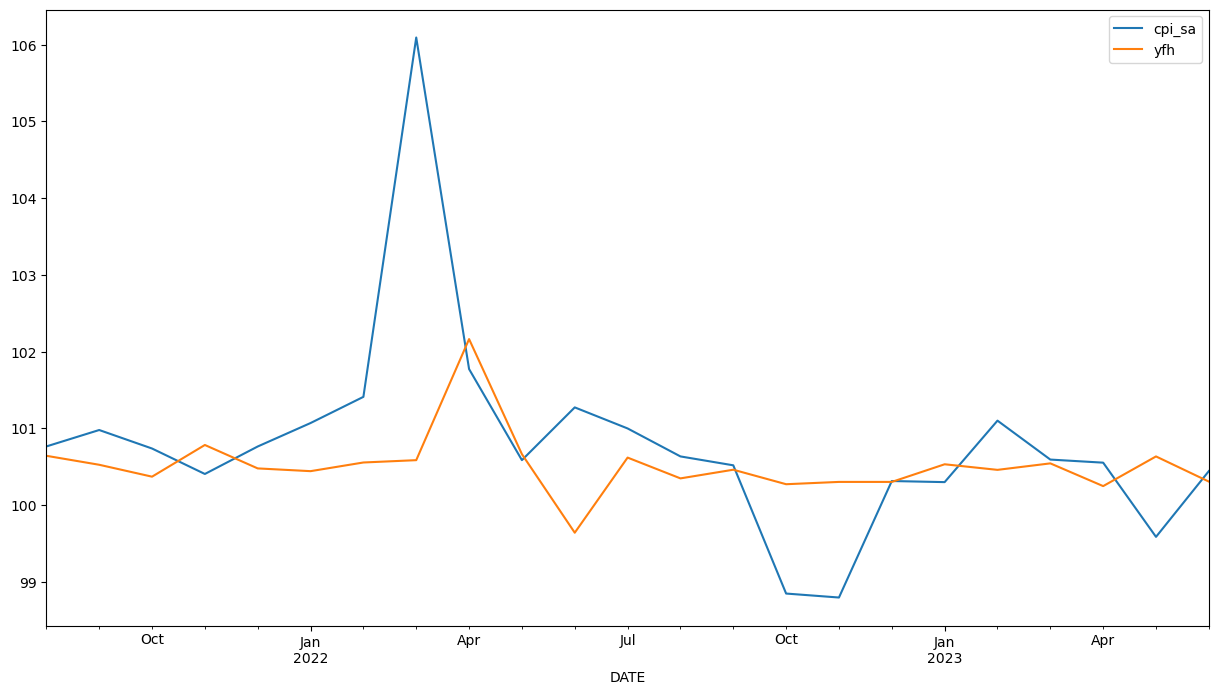

In [115]:
df_cpi = pd.concat([cpi_sa['cpi_sa']['2021-08-01':'2023-06-01'], forecast_df['yfh']], axis=1)
df_cpi[['cpi_sa', 'yfh']].plot(figsize=(15,8), style=['-', '-'])
None

## Параметры (2, 4)

In [92]:
K_1 = 1
K_2 = 3
y, yl, x, yf, ylf, xf = mix_freq(cpi_sa.cpi_sa, ex_rates.usd_byn_stationary, K_1, K_2, 2,
                                 start_date=datetime.datetime(2016,7,1),
                                 end_date=datetime.datetime(2023,2,1))

model = estimate(y, yl, x, poly='expalmon')
print(*model.x)
#opt params [beta0, beta1, beta2, theta11, theta12, theta21, theta22, lambda]

62.35689181755167 -2.1263258288736626 -1.0 0.0 0.33797309724356306 -0.016072216129265238 0.05826361306025185


In [93]:
fc = forecast(xf, ylf, model, poly='expalmon')
forecast_df = fc.join(yf)
forecast_df['residual'] = forecast_df.yfh - forecast_df.cpi_sa
print('RMSE =', np.sqrt(mean_squared_error(cpi_sa[['cpi_sa']].loc['2023-03-01':'2023-06-01'], forecast_df.yfh)))
print('MAE =', mean_absolute_error(cpi_sa[['cpi_sa']].loc['2023-03-01':'2023-06-01'], forecast_df.yfh))
forecast_df.head()

RMSE = 0.5344692624212368
MAE = 0.3488651125389488


,yfh,cpi_sa,residual
DATE,,,
2023-03-01,100.756431,100.592965,0.163466
2023-04-01,100.555522,100.552724,0.002798
2023-05-01,100.624717,99.585597,1.039121
2023-06-01,100.252889,100.442965,-0.190076


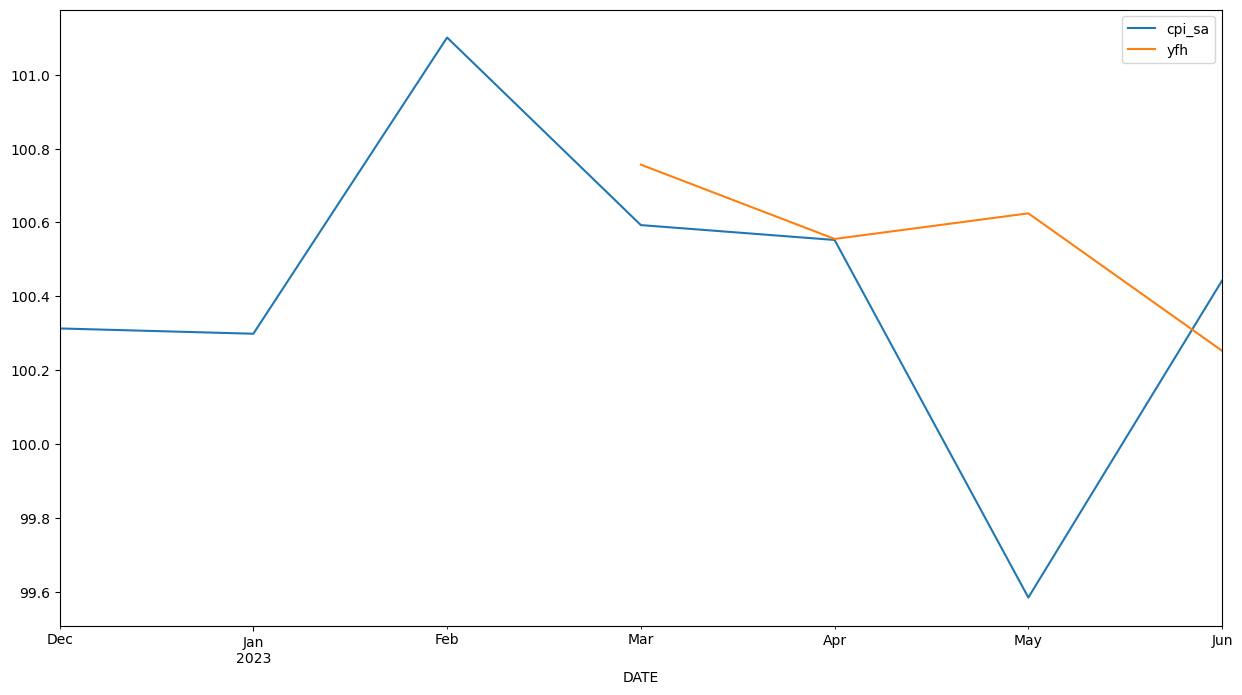

In [94]:
df_cpi = pd.concat([cpi_sa['cpi_sa']['2022-12-01':'2023-06-01'], forecast_df['yfh']], axis=1)
df_cpi[['cpi_sa', 'yfh']].plot(figsize=(15,8), style=['-', '-'])
None

## Параметры (8, 10)

In [171]:
K_1 = 2
K_2 = 1
y, yl, x, yf, ylf, xf = mix_freq(target, ex_rates.usd_byn_stationary, K_1, K_2, 2,
                                 start_date=datetime.datetime(2016,7,1),
                                 end_date=datetime.datetime(2023,2,1))

model = estimate(y.cpi_sa, yl, x, poly='beta')
print(*model.x)
#opt params [beta0, beta1, beta2, theta11, theta12, theta21, theta22, lambda]

43.26333724743842 -9.38565834241311 1.0 5.0 0.5702610888272623 -2.3329410968796336 -0.05510749641059303


In [172]:
fc = forecast(xf, ylf, model, poly='beta')
forecast_df = fc.join(yf)
forecast_df['residual'] = forecast_df.yfh - forecast_df.cpi_sa
print('RMSE =', np.sqrt(mean_squared_error(cpi_sa[['cpi_sa']].loc['2023-03-01':'2023-06-01'], forecast_df.yfh)))
print('MAE =', mean_absolute_error(cpi_sa[['cpi_sa']].loc['2023-03-01':'2023-06-01'], forecast_df.yfh))
forecast_df.head()

RMSE = 0.5921393355992749
MAE = 0.449566312020238


,yfh,cpi_sa,dum,dum,residual
DATE,,,,,
2023-03-01,100.907044,100.592965,0,0,0.314078
2023-04-01,100.548282,100.552724,0,0,-0.004442
2023-05-01,100.648756,99.585597,0,0,1.063159
2023-06-01,100.026379,100.442965,0,0,-0.416586


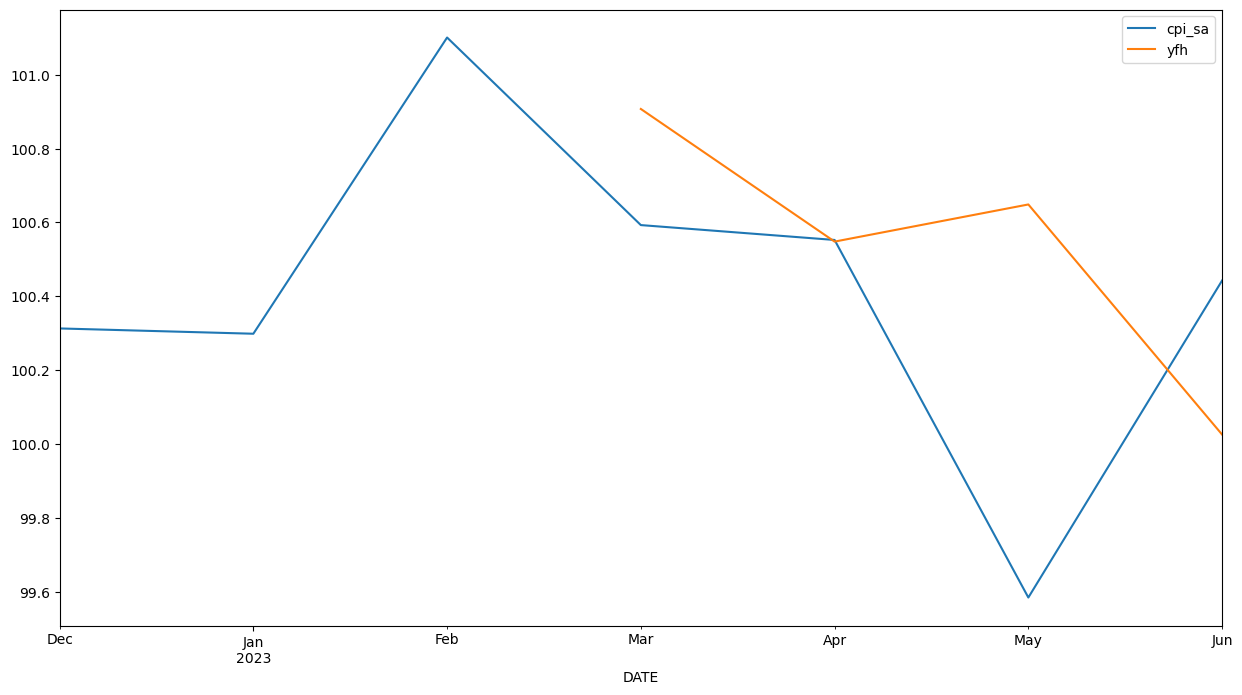

In [173]:
df_cpi = pd.concat([cpi_sa['cpi_sa']['2022-12-01':'2023-06-01'], forecast_df['yfh']], axis=1)
df_cpi[['cpi_sa', 'yfh']].plot(figsize=(15,8), style=['-', '-'])
None

# Прогнозирование ИПЦ

# Exp Alm Lags

In [101]:
K_1 = 1
K_2 = 2
y, yl, x, yf, ylf, xf = mix_freq(cpi_q_sa.cpi_sa, ex_rates.rur_byn_stationary, K_1, K_2, 2,
                                 start_date=datetime.datetime(2016,7,1),
                                 end_date=datetime.datetime(2022,10,1))

model = estimate(y, yl, x, poly='expalmon')

In [102]:
fc = forecast(xf, ylf, model, poly='expalmon')
forecast_df = fc.join(yf)
forecast_df['residual'] = forecast_df.yfh - forecast_df.cpi_sa
print('RMSE =', np.sqrt(mean_squared_error(cpi_q_sa[['cpi_sa']].loc['2022-11-01':'2023-06-01'], forecast_df.yfh)))
print('MAE =', mean_absolute_error(cpi_q_sa[['cpi_sa']].loc['2022-11-01':'2023-06-01'], forecast_df.yfh))
forecast_df.head()

RMSE = 0.5449317099704336
MAE = 0.5086008381834546


,yfh,cpi_sa,residual
date,,,
2023-01-01,100.854450,100.541491,0.312959
2023-04-01,101.333514,100.629271,0.704243


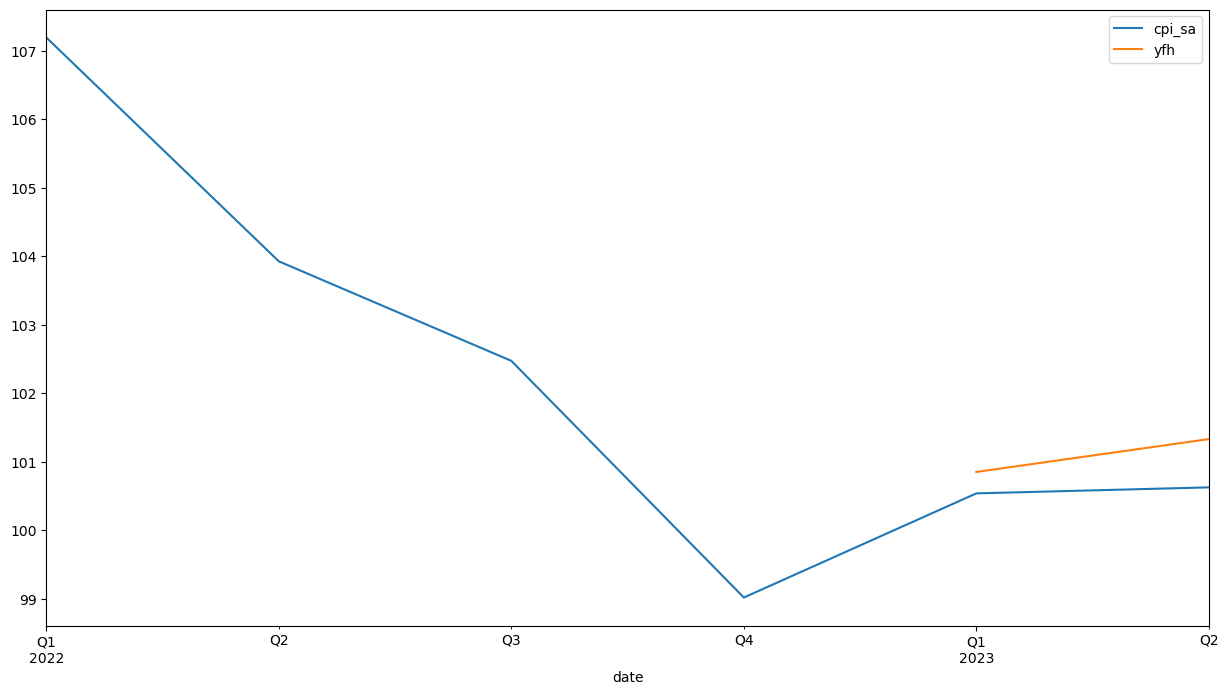

In [103]:
df_cpi = pd.concat([cpi_q_sa['cpi_sa']['2021-12-01':'2023-06-01'], forecast_df['yfh']], axis=1)
df_cpi[['cpi_sa', 'yfh']].plot(figsize=(15,8), style=['-', '-'])
None